In [1]:
import yaml
import numpy as np
import time

import threading
import time
import logging
import sys
sys.path.append("core")
from Environnement import *
from Simulation import *
from Player import *
from utils import *
from Functions import *
import re
import matplotlib.pyplot as plt 
logging.basicConfig(level=logging.ERROR,
                    format='[%(levelname)s] (%(threadName)) : %(message)s',
                    )

### Define vehicles and tasks sets

In [2]:
# 4 vehicules and 3 tasks (plus the null task)
vehicles = [0,1,2,3] # 4 vehicules
tasks = [0,1,2]

### Create random utility matrix

We use a matrix to store the utilities of the vehicles for the different possible allocations.
The advantage of using a matrix compared to storing all the possible combinations in a dictionary, a hashmap or similar, is that we save a lot of space because we don't have to store the keys, and the acces time is the same. The other advantage is that we can loop easily on the matrix and use optimized numpy functions over this matrix. Using a matrix could also be interesting to move the computations on GPU to speed it up for high dimentionnal instances.

In [3]:
#Give the shape of the utility matrix

shapes = getUtilityShape(len(vehicles),len(tasks))
print(shapes)

(3, 3, 3, 3, 4)


In [4]:
# create utility matrix with random utilities carrying the null action
ut_range = (0, 10) #range of the values taken by the utilities
ut = getRandomUt(len(vehicles),len(tasks), ut_range)

In [5]:
# create utility matrix with random and equaly shared utilities carrying the null action
ut = getEqualySharedUt(len(vehicles),len(tasks), ut_range)

In [6]:
ut[0][1][2][2] # get utility of all agents when allocation for vehicles to task is = 0,1,2,2 
# (means vehicule 0 do task 0, vehicule 1 do task 1, vehicule 2 do task 2, vehicule 3 do task 2)

array([0, 5, 5, 5])

### Defining usefull functions

In [7]:
# We create an environment of agent according to nb of tasks, agents and a matrix utility given or not
env = Environnement(len(tasks),len(vehicles), utilities = ut)

# Check if the current allocation is a Nash Equilibrium or not
en = env.is_EN()
print(en)

(False, 0)


We also return the id of one vehicle that can increase its utility by changing its allocation, if the solution is not a Nash Equilibrium. 
It didn't increase the computation cost and avoids looping another time later on the utility table to find one in the Best Response Dynamics, it's all benefits.

##### Nash Equilibrium test example on small dimension

In [8]:
# Create setup : 2 vehicles, 3 tasks
v = [0,1] # don't change, it's 2D example
t = [0,1,2]

env_test = Environnement(len(t),len(v))

env_test.utility

array([[[0, 0],
        [0, 8],
        [0, 8],
        [0, 3]],

       [[2, 0],
        [6, 4],
        [4, 8],
        [7, 3]],

       [[5, 0],
        [9, 2],
        [1, 4],
        [8, 4]],

       [[0, 0],
        [1, 6],
        [3, 1],
        [1, 4]]])

In [9]:
# Check EN for allocation (0,0)
env_test.allocation = np.array([0,0]) # set allocation to check (0,0) -> first vehicle do task 0 and second do task 0
env_test.is_EN() 

(False, 0)

In [10]:
env_test.utility[2][1] = [10,10] # set another allocation to a better score for one vehicle (in case matrix is full zero)
env_test.allocation = np.array([2,1])
env_test.is_EN()  # -> Is necessarly an EN because we set the maximum score (result must be True)

(True, -1)

In [11]:
def metric(m, utilities):
    if m == "sum":
        return np.sum(utilities)
    # TODO : add other metrics
    
def getAgent(env, id_a, type_a, fadding = 0, inertia = 0):
    if type_a == "Random":
        return RandomPlayer(env, id_a)
    if type_a == "FictitiousPlay":
        return FPPlayer1(env, id_a)
    if type_a == "RegretMatching":
        return RegretMatchingPlayer(env, id_a)
    if type_a == "BestResponse":
        return BRPlayer(env, id_a)
    if type_a == "SpatialAdaptative":
        return SAPlayer(env, id_a)
    if type_a == "SpatialFictitious":
        return SpatialFictiousPlayPlayer(env, id_a)
    if type_a == "GeneralizedRegret":
        return GeneralizedRegretMatchingPlayer(env, id_a, fadding_factor = fadding, inertia_factor = inertia)

def run_homogeneous(type_agent, nb_agents, nb_tasks, steps = 100, utility = np.zeros(1), fadding = 0, inertia = 0):
    utility_evolution = []
    agents = []
    
    #creating the environment
    if(utility.all() == 0):
        env = Environnement(nb_tasks,nb_agents, utilities = getEqualySharedUt(nb_agents, nb_tasks,(0,10)))
    else:  
        env = Environnement(nb_tasks,nb_agents, utilities = getEqualySharedUt(nb_agents, nb_tasks,(0,10))) 
            
    for j in range(nb_agents): #create nb_agents agents of this type
            ag = getAgent(env, j, type_agent, fadding, inertia)
            agents.append(ag)
    
    for s in range(steps):
        threads = []
        for a in agents : # getting agent threads
            t = threading.Thread(name="Player "+str(a.id), target=a.getWorkerFunction(1,verbose=False))
            threads.append(t)
        for th in threads : #starting the threads
            th.start()
        for th in threads : # join all (wait all ended)
            th.join()
            
        currentAlloc = env.allocation

        currentUt = env.utility[tuple(currentAlloc)]

        utility_evolution.append(metric("sum", currentUt))
        
    plt.figure()
    plt.plot(list(range(len(utility_evolution))), utility_evolution)
    plt.plot(list(range(len(utility_evolution))), len(utility_evolution)*[env.global_opt], c="red")
    plt.title(type_agent + ' : ' + str(nb_agents))
    plt.show()
    print("Final allocation = ", env.allocation)
    print("Utilities corresponding to this allocation = ", env.utility[tuple(env.allocation)])
    print("Sum of Utilities corresponding to this allocation = ", metric("sum", env.utility[tuple(env.allocation)]))
    print("Sum of Utilities corresponding to the opt allocation = ", env.global_opt)
    
    return env.allocation


### Best Response Dynamics

We are going to call the run_homogenous function for running our Best Response Dynamics agents.

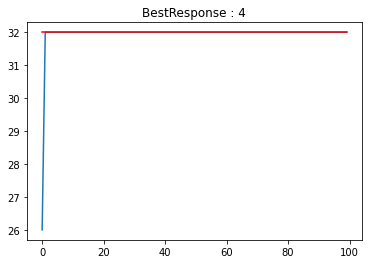

Final allocation =  [2 3 1 2]
Utilities corresponding to this allocation =  [8 9 9 6]
Sum of Utilities corresponding to this allocation =  32
Sum of Utilities corresponding to the opt allocation =  32


array([2, 3, 1, 2])

In [12]:
run_homogeneous("BestResponse", len(vehicles), len(tasks))

##### Best Response Dynamics test example on the initial matrix

In [13]:
ut[2,2,1,1] = [10,10,10,10] # we create a global optimal affectation -> At least one EN in utilities table

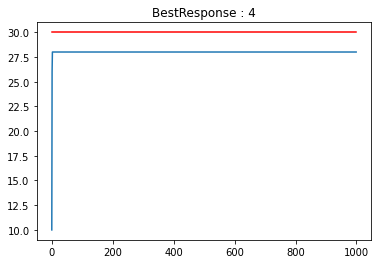

Final allocation =  [3 2 2 1]
Utilities corresponding to this allocation =  [6 7 9 6]
Sum of Utilities corresponding to this allocation =  28
Sum of Utilities corresponding to the opt allocation =  30


array([3, 2, 2, 1])

In [14]:
run_homogeneous("BestResponse", len(vehicles), len(tasks), steps = 1000, utility = ut)

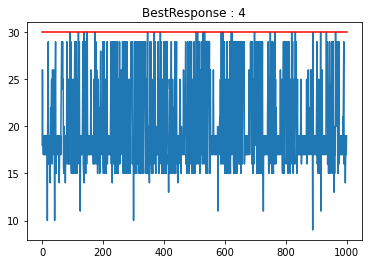

Final allocation =  [2 3 3 1]
Utilities corresponding to this allocation =  [3 3 6 7]
Sum of Utilities corresponding to this allocation =  19
Sum of Utilities corresponding to the opt allocation =  30


array([2, 3, 3, 1])

In [15]:
# another Nash Equilibrium is sometimes reached
run_homogeneous("BestResponse", len(vehicles), len(tasks), steps = 1000, utility = ut) 

### Fictitious Play

In [16]:
# testing expectation computation
frequencies = np.random.random((4,10)) # random frequencies (note that sum != 1, it's just for example)

for v in vehicles : # get the task with the highest utility expectation for each vehicle
    expect = computePartialFrequencyMatrix(ut, frequencies, vehicles, tasks, v)
    print(str(expect)+" --> task "+str(np.argmax(expect)))

[0.0, 1.7663535906162782, 1.6333602950394903] --> task 1
[0.0, 6.557266886481542, 5.853668003067117] --> task 1
[0.0, 4.8458410883594025, 5.88673646606085] --> task 2
[0.0, 1.8393995933805265, 1.6889001007371676] --> task 1


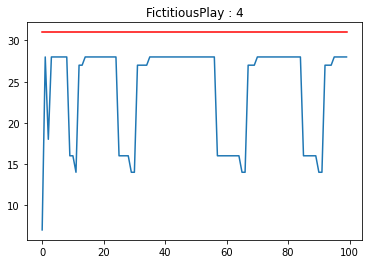

Final allocation =  [2 1 2 2]
Utilities corresponding to this allocation =  [9 4 8 7]
Sum of Utilities corresponding to this allocation =  28
Sum of Utilities corresponding to the opt allocation =  31


array([2, 1, 2, 2])

In [17]:
run_homogeneous("FictitiousPlay", len(vehicles), len(tasks)) 

In [18]:
# testing FP compared to BRD on the same utility matrix :

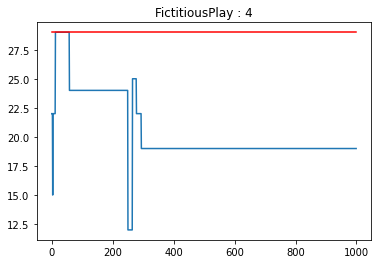

Final allocation =  [2 3 3 3]
Utilities corresponding to this allocation =  [1 7 6 5]
Sum of Utilities corresponding to this allocation =  19
Sum of Utilities corresponding to the opt allocation =  29


array([2, 3, 3, 3])

In [19]:
run_homogeneous("FictitiousPlay", len(vehicles), len(tasks), steps = 1000, utility = ut) 

In [20]:
# (if cells before have been re-run, it's no more the same ut matrix so no more the same results)
# obtained with fictitious play :  
# [2,1,1,0]  (maxsteps 500)
# [2,1,2,0]  (maxsteps 1500)
print("FP : "+str(ut[2,1,1,0])+" -> mean "+str(np.mean(ut[2,1,1,0])))
print("FP : "+str(ut[2,1,2,0])+" -> mean "+str(np.mean(ut[2,1,2,0])))

# obtained with best response dynamic : 
# [1,2,0,0]  (maxsteps 1000)
# [2,0,1,2]  (maxsteps 1000)
# [0,0,2,1]  (maxsteps 1000)

print("BRD : "+str(ut[1,2,0,0])+" -> mean "+str(np.mean(ut[1,2,0,0])))
print("BRD : "+str(ut[2,0,1,2])+" -> mean "+str(np.mean(ut[2,0,1,2])))
print("BRD : "+str(ut[0,0,2,1])+" -> mean "+str(np.mean(ut[0,0,2,1])))

FP : [1 1 1 0] -> mean 0.75
FP : [7 7 7 0] -> mean 5.25
BRD : [7 7 0 0] -> mean 3.5
BRD : [5 0 5 5] -> mean 3.75
BRD : [0 0 5 5] -> mean 2.5


### Regret Matching

In [21]:
def computeR(R, u, k, tasks, alloc, v): # not used
    """ Update the average regret table of vehicle v for not proposing each task
    
    Parameters:
        R : np.array(float) the regret table for each action at each step k (size: steps*tasks)
        u : the utility matrix
        k : int, the current time step
        tasks : List(int), the list of tasks id
        alloc : List(int), the current allocation
        v : int, the vehicle
    
    """
    if k == 0:
        return
    for t in tasks :
        loss = u[tuple(replaceAlloc(alloc, v, t))][v] - u[alloc][v]
        R[k+1,t] = ((k-1)/k)*R[k,t] + (1/k) * loss

def getNextR(lastR, u, k, tasks, alloc, v):
    """ Compute the average regret vector of vehicle v for not proposing each task, based on last regret vector
    
    Parameters:
        lastR : np.array(float) the regret vactor for each task at last step k-1
        u : the utility matrix
        k : int, the current time step
        tasks : List(int), the list of tasks id
        alloc : List(int), the current allocation
        v : int, the vehicle
    Return:
        np.array(float) the regret vactor for each action at current step k
    """
    if k == 0:
        return np.zeros(len(tasks))
    else :
        return np.array([((k-1)/k)*lastR[t] + (1/k) * (u[tuple(replaceAlloc(alloc, v, t))][v] - u[alloc][v]) for t in tasks])
 

In [22]:
# computing regret during random play using a regret table
v=0
total_steps = 10
R = np.zeros((total_steps, len(tasks)))
for i in range(9) : # computing regret during random play
    computeR(R, ut, i, tasks, tuple(np.random.randint(0,len(tasks),len(vehicles))),v)
    
R # regret at each step k

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  5.        ,  6.        ],
       [-2.5       ,  2.5       ,  4.        ],
       [-1.66666667,  3.        ,  3.66666667],
       [-2.        ,  2.25      ,  2.5       ],
       [-2.8       ,  1.6       ,  2.        ],
       [-2.33333333,  2.        ,  2.16666667],
       [-2.28571429,  1.85714286,  1.85714286],
       [-2.        ,  1.875     ,  2.125     ]])

In [23]:
# computing it during random play with last regret only (no regret table)
v=0
lastR = np.zeros(len(tasks)) 
for k in range(9) : # computing regret during random play
    lastR = getNextR(lastR, ut, k, tasks, tuple(np.random.randint(0,len(tasks),len(vehicles))),v)
    print(lastR)

[0. 0. 0.]
[ 0.  5. 10.]
[-2.  4.  5.]
[-3.          1.          3.33333333]
[-2.25  0.75  3.75]
[-3.   0.6  2.6]
[-3.5        -0.33333333  2.16666667]
[-3.85714286 -0.42857143  1.85714286]
[-3.375  0.375  2.625]


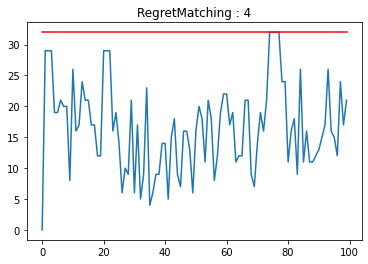

Final allocation =  [3 1 3 3]
Utilities corresponding to this allocation =  [3 9 1 8]
Sum of Utilities corresponding to this allocation =  21
Sum of Utilities corresponding to the opt allocation =  32


array([3, 1, 3, 3])

In [24]:
run_homogeneous("RegretMatching", len(vehicles), len(tasks)) 

In [25]:
#run the method on the same ut matrix :

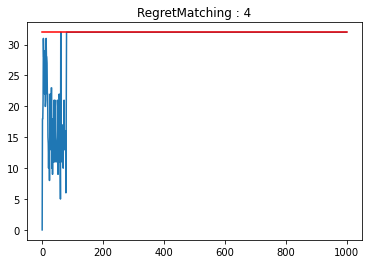

Final allocation =  [2 3 1 3]
Utilities corresponding to this allocation =  [9 9 6 8]
Sum of Utilities corresponding to this allocation =  32
Sum of Utilities corresponding to the opt allocation =  32


array([2, 3, 1, 3])

In [26]:
run_homogeneous("RegretMatching", len(vehicles), len(tasks), steps = 1000, utility = ut) 

### Spatial Adaptative Play

In [27]:
def computeSAPproba(utilities, alloc, vehicle, tasks, ro = 0.1):
    Uv = np.array([utilities[tuple(replaceAlloc(alloc, vehicle, t))][vehicle] for t in tasks])
    #print("utilities for each task : "+str(Uv))
    proba = softmax(Uv/ro) # use softmax or logit function
    return proba

In [28]:
allocation = [0, 2, 1, 2]
computeSAPproba(ut, allocation, 1, tasks, ro = 1) # small ro value : probas are unbalanced (very small random)

array([0.01766842, 0.01766842, 0.96466316])

In [29]:
computeSAPproba(ut, allocation, 1, tasks, ro = 0.1) # very small ro value : probas are very unbalanced (no random)

array([4.24835426e-18, 4.24835426e-18, 1.00000000e+00])

In [30]:
computeSAPproba(ut, allocation, 1, tasks, ro = 1000) # very high ro value : probas are ~ uniform (a lot of random)

array([0.33288859, 0.33288859, 0.33422281])

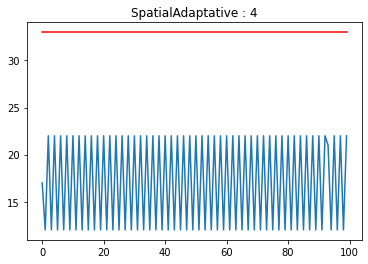

Final allocation =  [3 3 3 1]
Utilities corresponding to this allocation =  [5 3 5 9]
Sum of Utilities corresponding to this allocation =  22
Sum of Utilities corresponding to the opt allocation =  33


array([3, 3, 3, 1])

In [31]:
run_homogeneous("SpatialAdaptative", len(vehicles), len(tasks)) 

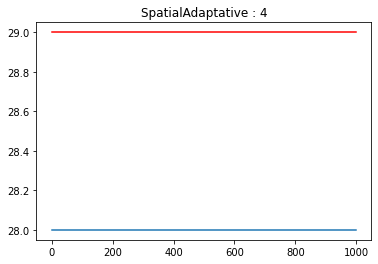

Final allocation =  [3 2 3 1]
Utilities corresponding to this allocation =  [5 7 9 7]
Sum of Utilities corresponding to this allocation =  28
Sum of Utilities corresponding to the opt allocation =  29


array([3, 2, 3, 1])

In [32]:
# spatial adaptative play on the same utility matrix ut
run_homogeneous("SpatialAdaptative", len(vehicles), len(tasks), steps = 1000, utility = ut) 

### Comparing the different negociation methods :

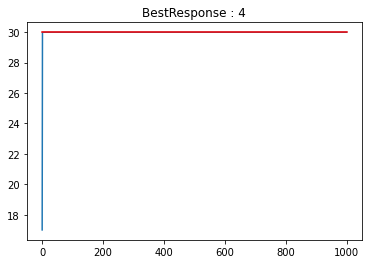

Final allocation =  [1 1 1 1]
Utilities corresponding to this allocation =  [8 6 7 9]
Sum of Utilities corresponding to this allocation =  30
Sum of Utilities corresponding to the opt allocation =  30
DMR : (1, 1, 1, 1)


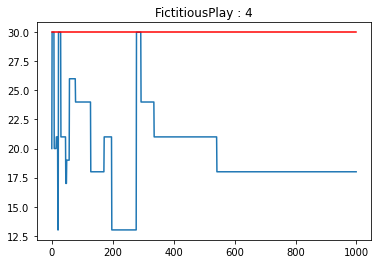

Final allocation =  [1 1 2 3]
Utilities corresponding to this allocation =  [3 2 7 6]
Sum of Utilities corresponding to this allocation =  18
Sum of Utilities corresponding to the opt allocation =  30
FP : (1, 1, 2, 3)


IndexError: index 3 is out of bounds for axis 3 with size 3

In [33]:
# compare utility sum and execution time of the 3 methods
score_DMR = []
time_DMR = []
score_FP = []
time_FP = []
score_RM = []
time_RM = []
score_SAP = []
time_SAP = []
for step in range(10):# 10 different utility matrix
    ut = np.random.randint(0,10,shapes) # create utility matrix with random utilities
    for repeat in range(10): # 10 repeats on each utility matrix
        # best response dynamic
        start = time.time()
        alloc = tuple(run_homogeneous("BestResponse", len(vehicles), len(tasks), steps = 1000, utility = ut))
        duration = time.time() - start
        print("DMR : "+str(alloc))
        #print(ut[alloc])
        score_DMR.append(np.sum(ut[alloc]))
        time_DMR.append(duration)

        # fictitious play
        start = time.time()
        alloc = tuple(run_homogeneous("FictitiousPlay", len(vehicles), len(tasks), steps = 1000, utility = ut))
        duration = time.time() - start
        print("FP : "+str(alloc))
        #print(ut[alloc])
        score_FP.append(np.sum(ut[alloc]))
        time_FP.append(duration)

        # regret matching
        start = time.time()
        alloc = tuple(run_homogeneous("RegretMatching", len(vehicles), len(tasks), steps = 1000, utility = ut))
        duration = time.time() - start
        print("RM : "+str(alloc))
        #print(ut[alloc])
        score_RM.append(np.sum(ut[alloc]))
        time_RM.append(duration)

        # spatial adaptative play
        start = time.time()
        alloc = tuple(run_homogeneous("SpatialAdaptative", len(vehicles), len(tasks), steps = 1000, utility = ut))
        duration = time.time() - start
        print("SAP : "+str(alloc))
        #print(ut[alloc])
        score_SAP.append(np.sum(ut[alloc]))
        time_SAP.append(duration)

In [ ]:
# on a first utility matrix :
print("mean DMR : "+str(np.mean(score_DMR))+" average time : "+str(np.mean(time_DMR)))
print("mean FP : "+str(np.mean(score_FP))+" average time : "+str(np.mean(time_FP)))
print("mean RM : "+str(np.mean(score_RM))+" average time : "+str(np.mean(time_RM)))
print("mean SAP : "+str(np.mean(score_SAP))+" average time : "+str(np.mean(time_SAP)))

In [ ]:
np()

## Running experiments

### Load an experiment

In [35]:
def read_experiments(filename, verbose=True):
    with open(r''+filename) as file:
        experiments = yaml.full_load(file)
        if verbose :
            for exp, content in experiments.items():
                print(key, ":", content)
        return experiments

In [37]:
#Example
exp = read_experiments('core/exp.yaml', False)
print(exp)

{'Experience1': {'nb_steps': 1000, 'nb_sync': 100, 'tasks': 3, 'Type1': {'number': 3, 'type': 'RegretMatching', 'spec': {'intertia': 0.1, 'fadding': 0.2}}, 'Type2': {'number': 2, 'type': 'FictiousPlay'}, 'Type3': {'number': 3, 'type': 'Random'}}, 'Experience2': {'tasks': 3, 'Type1': {'number': 3, 'type': 'RegretMatching', 'spec': {'intertia': 0.1, 'fadding': 0.2}}, 'Type2': {'number': 2, 'type': 'FictiousPlay'}, 'Type3': {'number': 1, 'type': 'Random'}}}


### Generating experiments (all combinations)

In [38]:
# Available Agent Types :
types = {0 : "RegretMatching", 1 : "FictitiousPlay", 2 : "Random", 3 : "BestResponse", 
         4 : "SpacialAdaptative"}

nb_vehicles = 3 # for 3 vehicles and 4 tasks, 125 possible combinations
nb_tasks = 4

alloc_dim = np.zeros([len(types)]*nb_vehicles)
allAlloc = [x for x,_ in np.ndenumerate(alloc_dim)]
print("Lenght of all the possible allocation: ", len(allAlloc))

Lenght of all the possible allocation:  125


#### Creating an experiment file containing an experiment for each possible combination with 5 possible types of players, with 4 tasks and 3 players.

In [40]:
def create_experiments(nb_steps, nb_agents, nb_tasks, nb_sync=100):
    # Available Types :
    types = {0 : "RegretMatching", 1 : "FictitiousPlay", 2 : "Random", 3 : "BestResponse", 
         4 : "SpatialAdaptative"}
    alloc_dim = np.zeros([len(types)]*nb_vehicles)
    allAlloc = [x for x,_ in np.ndenumerate(alloc_dim)]
    repartitions = []
    exp = {}
    expId = 1
    for a in allAlloc:
        seen = []
        exp_dict = {}
        exp_dict['nb_sync'] = int(nb_sync)
        exp_dict['tasks'] = int(nb_tasks)
        typeId = 1
        repartition = np.zeros(len(types))
        for t in a :
            type_dict={}
            str_type = types[t]
            #print(seen)
            if str_type not in seen :
                seen.append(str_type)
                type_dict["type"] = str_type
                cnt = int((np.array(a)==t).sum())
                type_dict["number"] = cnt
                repartition[t] = cnt
                if str_type == "RegretMatching":
                    # default values
                    dict_spec = {"inertia": 0.1, "fadding" : 0.2}
                    type_dict["spec"] = dict_spec
                # save the agent params
                exp_dict["Type"+str(typeId)] = type_dict
                typeId += 1
        already_done = np.sum([1 if np.all(repartition == r) else 0 for r in repartitions])
        if already_done < 1 :
            # save the experiment setup
            exp["Experience"+str(expId)] = exp_dict
            expId += 1
            # remember done repartitions
            repartitions.append(repartition)
            #print(repartitions)
    return exp

In [41]:
exp_outp = create_experiments(100, 3, 4, nb_sync=100)

### Saving an experiment file

In [42]:
def write_exp_file(filename, exp):
    with open(r''+str(filename), 'w') as file:
        yaml.dump(exp, file)

In [43]:
write_exp_file("exp_3vehicles_4tasks.yaml", exp_outp)

### Run an experiment from yaml file

In [44]:
# Reading the experiment saved just before
myexp = read_experiments("exp_3vehicles_4tasks.yaml", False)

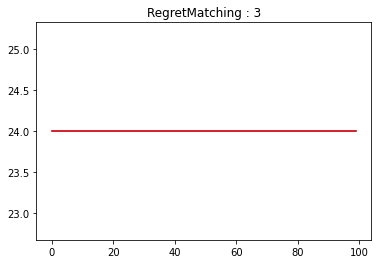

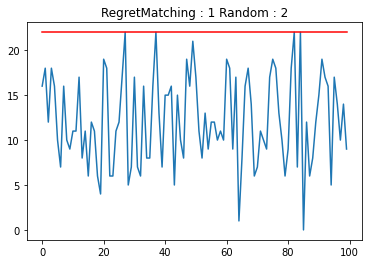

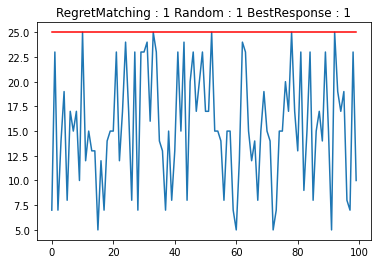

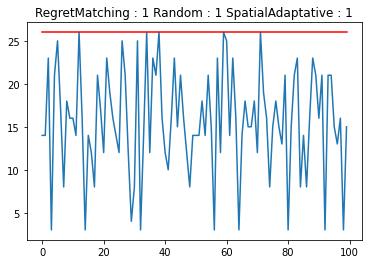

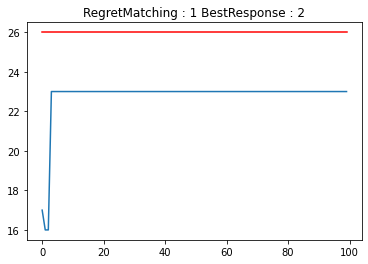

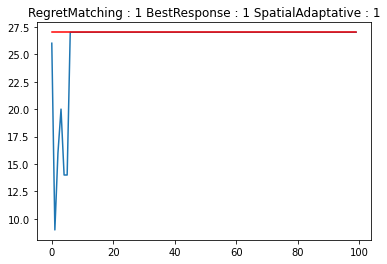

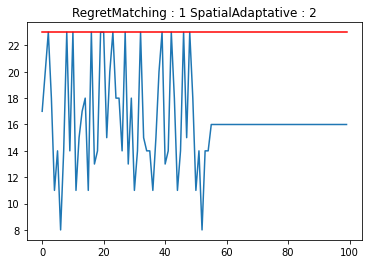

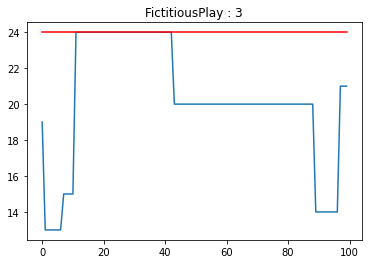

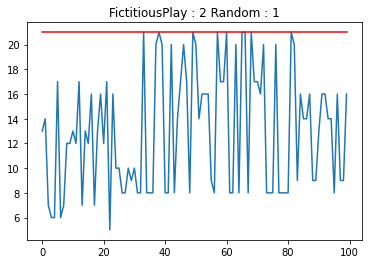

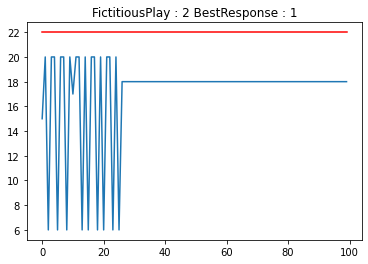

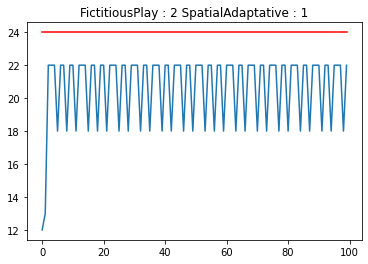

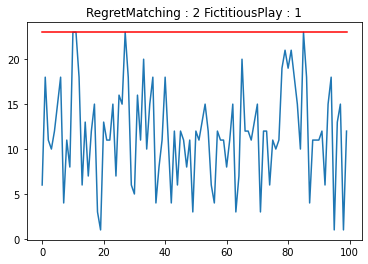

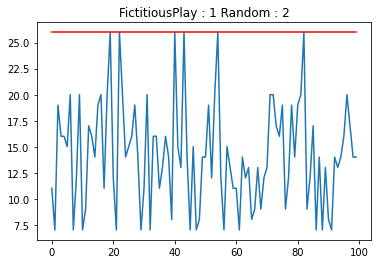

In [ ]:
import matplotlib.pyplot as plt 
logging.basicConfig(level=logging.ERROR,
                    format='[%(levelname)s] (%(threadName)) : %(message)s',
                    )
# run all the experiments and plot the curve
for exp in myexp.keys():
    utility_evolution = []
    #print(exp)
    nb_sync = myexp[exp]["nb_sync"]
    nb_tasks = myexp[exp]["tasks"]
    agents = []
    entrys = myexp[exp].keys()
    #print(entrys)
    res = []
    for i in entrys : # search for Type definitions only
        if len(re.findall('Type*', i)) > 0 :
            res.append(i)
    total_agents = 0
    for t in res :
        nb_t = myexp[exp][t]["number"] # number of agents of this type
        total_agents += nb_t
    #print(total_agents)
    env = Environnement(nb_tasks,total_agents, utilities = getEqualySharedUt(total_agents, nb_tasks,(0,10))) #creating the environment
    for t in res :
        if np.isin("spec",myexp[exp][t].keys()): # check if extra parameters
            fadding = myexp[exp][t]["spec"]["fadding"]
            inertia = myexp[exp][t]["spec"]["inertia"]
        else:
            fadding = 0
            inertia = 0
        for j in range(myexp[exp][t]["number"]): #create X agents of this type
            ag = getAgent(env, len(agents),myexp[exp][t]["type"], fadding, inertia)
            agents.append(ag)
    #print(agents)
    for steps in range(100):
        threads = []
        for a in agents : # getting agent threads
            t = threading.Thread(name="Player "+str(a.id), target=a.getWorkerFunction(5,verbose=False))
            threads.append(t)
        for th in threads : #starting the threads
            th.start()
        for th in threads : # join all (wait all ended)
            th.join()
        currentAlloc = env.allocation
        #print("alloc : "+str(currentAlloc))
        currentUt = env.utility[tuple(currentAlloc)]
        #print("utility : "+str(currentUt))
        utility_evolution.append(metric("sum", currentUt))
    plt.figure()
    plt.plot(list(range(len(utility_evolution))), utility_evolution)
    plt.plot(list(range(len(utility_evolution))), len(utility_evolution)*[env.global_opt], c="red")
    plt.title(" ".join([myexp[exp][t]["type"] + " : "+ str(myexp[exp][t]["number"]) for t in res]))
    plt.show()
    #print(env.is_EN())